# Stability 

In [2]:
import pickle
from glob import glob
from nilearn import image, datasets, masking
import nibabel as nib
import numpy as np
import pandas as pd
import os

In [3]:
def compute_intersection_mask(data_path, contrast, pipeline):
    data_fpath = glob(f'{data_path}/group-*_{contrast}_{pipeline}_tstat.nii*')
    mask_list = []
    
    print('Computing mask...')
    
    for fpath in data_fpath:
        
        img = nib.load(fpath)
        mask_img = image.binarize_img(img)
        mask_list.append(mask_img)

    mask = masking.intersect_masks(mask_list, threshold=1)

    return mask

def compute_correlation_matrix(data_path, contrast):
    
    if not os.path.exists(f"../figures/corr_matrix_24_pipelines_{contrast}"):
        
        print('Computing correlation matrix...')
        
        Qs=[]
        pipelines=[f'{soft}-{f}-{p}-{h}' for soft in ['spm','fsl'] for f in [5,8] for p in [0,6,24] for h in [0,1]]
        
        for pi in pipelines:
            data_fpath = sorted(glob(f'{data_path}/group-*_{contrast}_{pi}_tstat.nii'))
            data = []
            
            for fpath in data_fpath:

                img = nib.load(fpath)
                data.append(np.reshape(np.nan_to_num(img.get_fdata()),-1))
                
            Q = np.corrcoef(data)  
            Qs.append(Q)
            
        with open(f"../figures/corr_matrix_24_pipelines_{contrast}", "wb") as fp:   #Pickling
            pickle.dump(Qs, fp)

    else:
        with open(f"../figures/corr_matrix_24_pipelines_{contrast}", "rb") as fp:   #Pickling
            Qs=pickle.load(fp)

    return Qs

In [15]:
data_path = '../data/preprocessed/resampled_mni_masked_res_4'

contrast = 'right-foot'
Qs_rf = compute_correlation_matrix(data_path, contrast)

contrast = 'right-hand'
Qs_rh = compute_correlation_matrix(data_path, contrast)

contrast = 'left-foot'
Qs_lf = compute_correlation_matrix(data_path, contrast)

contrast = 'left-hand'
Qs_lh = compute_correlation_matrix(data_path, contrast)

contrast = 'tongue'
Qs_t = compute_correlation_matrix(data_path, contrast)

Computing correlation matrix...


In [16]:
stability_rf = {}
mean_sim_rf = []
for p in range(24):
    similarity_list = []
    for g in range(len(Qs_rf[p])):
        similarity = np.mean([np.mean(Qs_rf[p][g,:])])
        similarity_list.append(similarity)
    stability_rf[p] = similarity_list
    mean_sim_rf.append(np.mean(similarity_list))

In [17]:
stability_rh = {}
mean_sim_rh = []
for p in range(24):
    similarity_list = []
    for g in range(len(Qs_rh[p])):
        similarity = np.mean([np.mean(Qs_rh[p][g,:])])
        similarity_list.append(similarity)
    stability_rh[p] = similarity_list
    mean_sim_rh.append(np.mean(similarity_list))

In [18]:
stability_lf = {}
mean_sim_lf = []
for p in range(24):
    similarity_list = []
    for g in range(len(Qs_lf[p])):
        similarity = np.mean([np.mean(Qs_lf[p][g,:])])
        similarity_list.append(similarity)
    stability_lf[p] = similarity_list
    mean_sim_lf.append(np.mean(similarity_list))

In [19]:
stability_lh = {}
mean_sim_lh = []
for p in range(24):
    similarity_list = []
    for g in range(len(Qs_lh[p])):
        similarity = np.mean([np.mean(Qs_lh[p][g,:])])
        similarity_list.append(similarity)
    stability_lh[p] = similarity_list
    mean_sim_lh.append(np.mean(similarity_list))

In [20]:
stability_t = {}
mean_sim_t = []
for p in range(24):
    similarity_list = []
    for g in range(len(Qs_t[p])):
        similarity = np.mean([np.mean(Qs_t[p][g,:])])
        similarity_list.append(similarity)
    stability_t[p] = similarity_list
    mean_sim_t.append(np.mean(similarity_list))

In [21]:
import itertools
df_sim = pd.DataFrame()
pipelines=[f'{soft}-{f}-{p}-{h}' for soft in ['spm','fsl'] for f in [5,8] for p in [0,6,24] for h in [0,1]]
df_sim['Pipeline'] = [p for i in range(5) for p in pipelines ]
df_sim['Contrast'] = [c for c in ['left-foot', 'left-hand', 
                                 'right-foot', 'right-hand', 'tongue'] for p in range(24)]
df_sim['Similarities'] = list(itertools.chain(mean_sim_lf,mean_sim_lh,mean_sim_rf,mean_sim_rh, mean_sim_t))


In [37]:
cons = ['left-foot', 'left-hand', 
                                 'right-foot', 'right-hand', 'tongue']

for c in cons:
    max_sim = np.max(df_sim['Similarities'][df_sim['Contrast']==c].tolist())
    min_sim = np.min(df_sim['Similarities'][df_sim['Contrast']==c].tolist())
    
    print('Max:', df_sim['Pipeline'][df_sim['Similarities']==max_sim][df_sim['Contrast']==c].tolist()[0])
    print('Min:', df_sim['Pipeline'][df_sim['Similarities']==min_sim][df_sim['Contrast']==c].tolist()[0])

Max: fsl-8-0-0
Min: spm-5-24-1
Max: fsl-8-6-0
Min: spm-5-24-1
Max: fsl-8-0-0
Min: spm-5-24-1
Max: fsl-8-6-0
Min: spm-5-24-1
Max: fsl-8-0-0
Min: spm-5-24-1


In [41]:
for c in cons:
    print(df_sim[df_sim['Contrast']==c].sort_values(by = 'Similarities',ascending = False)[0:3])

      Pipeline   Contrast  Similarities
18   fsl-8-0-0  left-foot      0.863419
20   fsl-8-6-0  left-foot      0.857325
22  fsl-8-24-0  left-foot      0.851597
      Pipeline   Contrast  Similarities
44   fsl-8-6-0  left-hand      0.797986
46  fsl-8-24-0  left-hand      0.792893
47  fsl-8-24-1  left-hand      0.781089
      Pipeline    Contrast  Similarities
66   fsl-8-0-0  right-foot      0.828131
68   fsl-8-6-0  right-foot      0.823325
70  fsl-8-24-0  right-foot      0.815899
      Pipeline    Contrast  Similarities
92   fsl-8-6-0  right-hand      0.843478
94  fsl-8-24-0  right-hand      0.837618
90   fsl-8-0-0  right-hand      0.832234
       Pipeline Contrast  Similarities
114   fsl-8-0-0   tongue      0.888157
116   fsl-8-6-0   tongue      0.883806
118  fsl-8-24-0   tongue      0.878357


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, 'spm-5-0-0'),
  Text(1, 0, 'spm-5-0-1'),
  Text(2, 0, 'spm-5-6-0'),
  Text(3, 0, 'spm-5-6-1'),
  Text(4, 0, 'spm-5-24-0'),
  Text(5, 0, 'spm-5-24-1'),
  Text(6, 0, 'spm-8-0-0'),
  Text(7, 0, 'spm-8-0-1'),
  Text(8, 0, 'spm-8-6-0'),
  Text(9, 0, 'spm-8-6-1'),
  Text(10, 0, 'spm-8-24-0'),
  Text(11, 0, 'spm-8-24-1'),
  Text(12, 0, 'fsl-5-0-0'),
  Text(13, 0, 'fsl-5-0-1'),
  Text(14, 0, 'fsl-5-6-0'),
  Text(15, 0, 'fsl-5-6-1'),
  Text(16, 0, 'fsl-5-24-0'),
  Text(17, 0, 'fsl-5-24-1'),
  Text(18, 0, 'fsl-8-0-0'),
  Text(19, 0, 'fsl-8-0-1'),
  Text(20, 0, 'fsl-8-6-0'),
  Text(21, 0, 'fsl-8-6-1'),
  Text(22, 0, 'fsl-8-24-0'),
  Text(23, 0, 'fsl-8-24-1')])

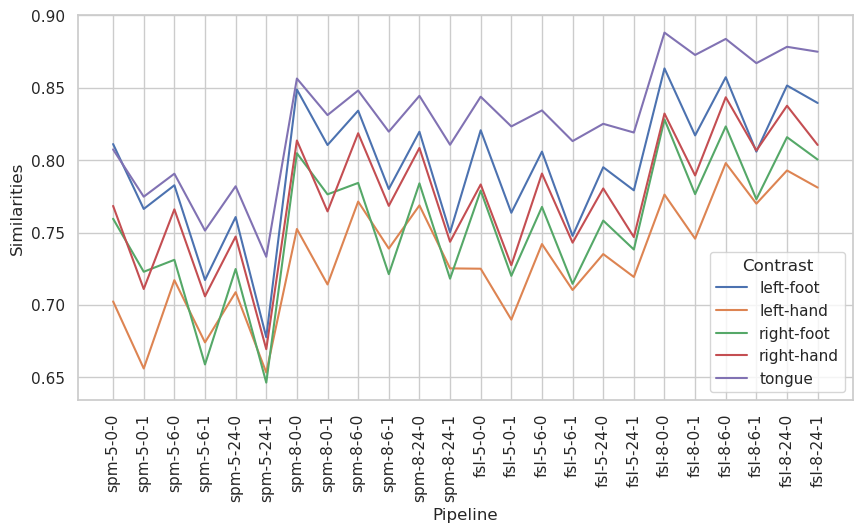

In [22]:
import matplotlib.pyplot as plt 
import seaborn as sns
f, axs = plt.subplots(1, 1, figsize=(10, 5)) 
sns.set_theme(style="whitegrid")
sns.lineplot(x='Pipeline',y='Similarities', hue='Contrast', data=df_sim, ax=axs)
plt.xticks(rotation=90)

In [35]:
from scipy import stats
stats.ttest_rel(mean_sim_rf, mean_sim_t)

TtestResult(statistic=-19.95725456057517, pvalue=5.066557493780891e-16, df=23)